Trước hết ta gọi các thư viện cần thiết và tạo dữ liệu – Dữ liệu training sẽ là (X, y):

In [1]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
np.random.seed(22)

means = [[2, 2], [4, 2]]
cov = [[.3, .2], [.2, .3]]
N = 100
X0 = np.random.multivariate_normal(means[0], cov, N) # class 1
X1 = np.random.multivariate_normal(means[1], cov, N) # class -1
X = np.concatenate((X0.T, X1.T), axis = 1) # all data
y = np.concatenate((np.ones((1, N)), -1*np.ones((1, N))), axis = 1) # labels

Chúng ta sẽ hiển thị dữ liệu trên hình vẽ để có quan sát trực quan

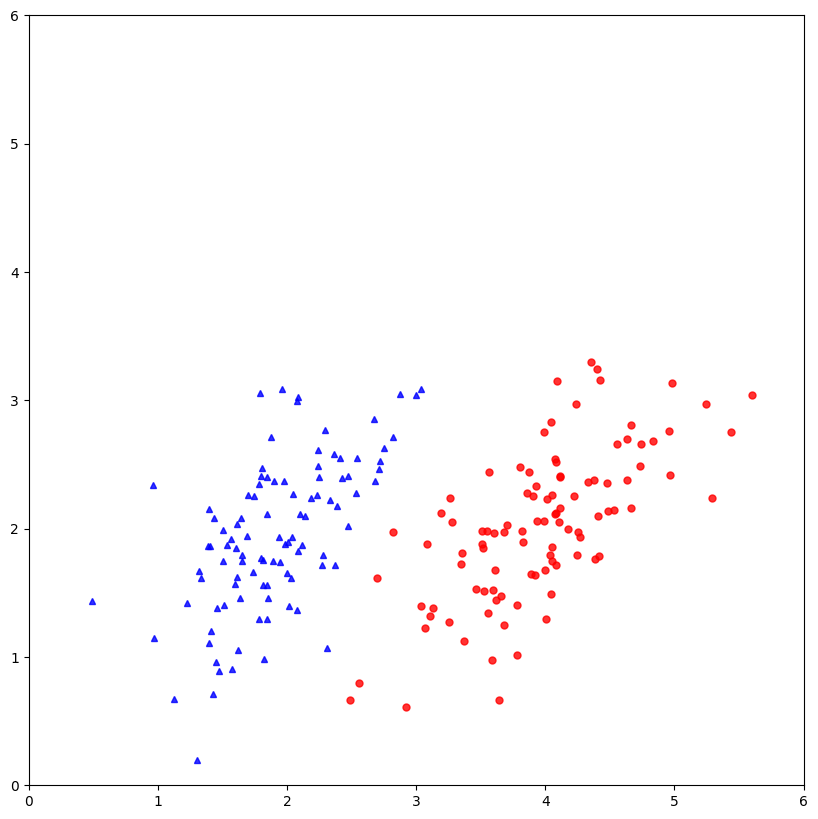

In [2]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 10))
ani = plt.cla()
#plot points
ani = plt.plot(X0.T[0, :], X0.T[1, :], 'b^', markersize = 5, alpha = .8)
ani = plt.plot(X1.T[0, :], X1.T[1, :], 'ro', markersize = 5, alpha = .8)
ani = plt.axis([0 , 6, 0, 6])
plt.show()

Tiếp theo chúng ta giải bài toán tối ưu - g()  min để tính  trước bằng thư viện CVXOPT

In [4]:
from cvxopt import matrix, solvers
# build K
V = np.concatenate((X0.T, -X1.T), axis = 1)
K = matrix(V.T.dot(V)) # see definition of V, K near eq (??)

p = matrix(-np.ones((2*N, 1))) # all-one vector
# build A, b, G, h
G = matrix(-np.eye(2*N)) # for all lambda_n >= 0! note that we solve -g(lambda) -> min
h = matrix(np.zeros((2*N, 1)))
A = matrix(y) # the equality constrain is actually y^T lambda = 0
b = matrix(np.zeros((1, 1)))
solvers.options['show_progress'] = False
sol = solvers.qp(K, p, G, h, A, b)

l = np.array(sol['x']) # lambda
print('lambda = ')
print(l.T)

lambda = 
[[5.92924398e-10 1.94139394e-09 3.84240658e-10 2.34590064e-09
  1.99860594e-09 1.65747762e-09 1.68596002e-09 1.05828021e-09
  1.67680410e-09 2.61227214e-09 2.59068293e-09 1.20191053e-09
  1.75995285e-09 1.66696815e-09 5.06420275e-10 3.00471043e-09
  1.46994496e-09 6.59850201e-10 1.70269435e-09 1.27207328e-09
  2.02130759e-09 1.19097145e-09 8.73613571e-10 2.07801810e-10
  3.15457750e-10 1.73784338e-09 1.18126342e-09 1.81094794e-09
  9.80210835e-10 2.84478869e-10 1.33542342e-09 1.24303751e-09
  1.80395436e-08 1.43745324e-09 1.62392389e-09 1.83974875e-09
  2.53966002e-10 1.70564370e-09 1.92398711e-09 3.08485833e-10
  1.60412081e-09 1.73669606e-09 2.64262343e-10 1.73952420e-09
  2.42376933e-09 3.57114903e+01 1.27412787e-09 1.42277650e-09
  1.48918195e-09 2.16249949e-09 2.08678373e-09 1.77004934e-09
  1.34113039e-09 1.85409124e-09 2.14778316e-09 1.53106273e-09
  1.64051465e-09 4.32408561e-10 1.53457308e-09 8.23766279e-10
  1.83555412e-09 1.79358082e-09 3.13552818e-09 3.45283742e-1

Do các giá trị  giải bằng thư viện CVXOPT được tính theo phương pháp lặp, nên hầu hết chúng không có giá
trị 0 tuyệt đối mà chỉ là rất nhỏ (cỡ 10-9). Vì vậy chúng ta sẽ cần loại bỏ các giá trị  quá nhỏ trong kết quả (thực
chất đó là 0 nhưng phương pháp giải lặp có sai số tính toán).
Trong đoạn chương trình dưới đây ta lọc các giá trị nhỏ hơn 10-6 sau đó tính w, w0 theo công thức lý thuyết.

In [26]:
epsilon = 1e-6 # just a small number, greater than 1e-9, to filter values of lambda
S = np.where(l > epsilon)[0]

VS = V[:, S]
XS = X[:, S]
yS = y[:, S]
lS = l[S]
# calculate w and b
w = VS.dot(lS)
b = np.mean(yS.T - w.T.dot(XS))

print('w = ', w.T)
print('b = ', b)


w =  [[-10.98164994   3.98551086]]
b =  22.07538419522531


Xem lại các bài ví dụ phần trước, sử dụng bộ trọng số W đã tính được và dự đoán các phân lớp y ứng với dữ liệu 
X trên chính tập dữ liệu ngẫu nhiên vừa tạo. Đưa ra độ chính xác Accuracy và ma trận nhầm lẫn Confusion 
Matrix. 

In [35]:
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix

# Ensure y is flattened to 1D
y_flat = y.flatten()

# Calculate the predicted labels
y_pred = np.sign(w.T @ X + b)  # This should be a 2xN matrix
y_pred = y_pred.flatten()  # Flatten to 1D array

# Check that y and y_pred have the same shape
assert y_flat.shape == y_pred.shape, "y and y_pred should have the same shape"

# Calculate accuracy
accuracy = accuracy_score(y_flat, y_pred)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_flat, y_pred)

# Output the results
print("Accuracy:", accuracy)
print("Confusion Matrix:")
print(conf_matrix)


Accuracy: 1.0
Confusion Matrix:
[[100   0]
 [  0 100]]


Cuối cùng, chúng ta vẽ kết quả để quan sát trực quan:

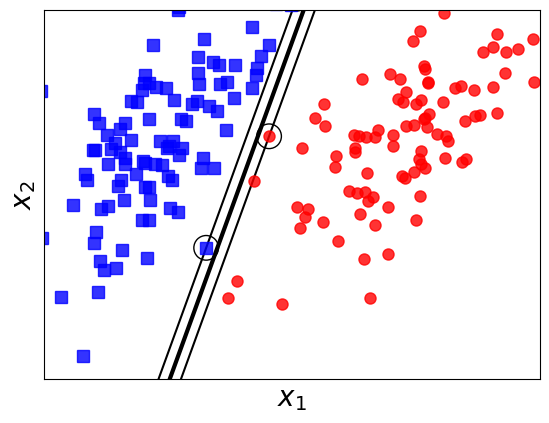

In [13]:
from matplotlib.backends.backend_pdf import PdfPages 
with PdfPages('D:\\Python\\MachineLearning\\MachineLearning\\week10\\data\\svm4hardmargin.pdf') as pdf: 
    # draw 
    # plot points 
    fig, ax = plt.subplots() 
 
    x1 = np.arange(-10, 10, 0.1) 
    y1 = -w[0, 0]/w[1, 0]*x1 - b/w[1, 0] 
    y2 = -w[0, 0]/w[1, 0]*x1 - (b-1)/w[1, 0] 
    y3 = -w[0, 0]/w[1, 0]*x1 - (b+1)/w[1, 0] 
    plt.plot(x1, y1, 'k', linewidth = 3) 
    plt.plot(x1, y2, 'k') 
    plt.plot(x1, y3, 'k') 
    y4 = 10*x1 
    plt.plot(x1, y1, 'k') 
    # plt.fill_between(x1, y1, color='red', alpha='0.1') 
    # plt.fill_between(x1, y1, y4, color = 'blue', alpha = '.1') 
 
 
    plt.plot(X0[:, 0], X0[:, 1], 'bs', markersize = 8, alpha = .8) 
    plt.plot(X1[:, 0], X1[:, 1], 'ro', markersize = 8, alpha = .8) 
 
    plt.axis('equal') 
    plt.ylim(0, 3) 
    plt.xlim(2, 4) 
 
    # hide tikcs  
    cur_axes = plt.gca() 
    cur_axes.axes.get_xaxis().set_ticks([]) 
    cur_axes.axes.get_yaxis().set_ticks([]) 
 
    # add circles around support vectors  
    for m in S: 
        circle = plt.Circle((X[0, m], X[1, m] ), 0.1, color='k', fill = False) 
        ax.add_artist(circle) 
 
 
    plt.xlabel('$x_1$', fontsize = 20) 
    plt.ylabel('$x_2$', fontsize = 20) 
#     plt.savefig('svm4.png', bbox_inches='tight', dpi = 300) 
    pdf.savefig() 
    plt.show() 

Sử dụng thư viện:  Cũng với dữ liệu như trên, nhưng trong phần này chúng ta sử dụng thư viện sklearn. 
Trước hết chúng ta cần lấy đoạn chương trình tạo dữ liệu ở phần a) để có dữ liệu. Sau đó đoạn chương trình 
gọi thư viện và thực hiện thuật toán SVM như sau 

In [14]:
from sklearn.svm import SVC 
# Copy and put code for generate data here 
y1 = y.reshape((2*N,)) 
X1 = X.T # each sample is one row 
clf = SVC(kernel = 'linear', C = 1e5) # just a big number  
# if C is small, method will be “SoftMagin SVM”,  
# if C is large enough, method is near to hard margin 
clf.fit(X1, y1)  
 
w = clf.coef_ 
w0 = clf.intercept_ 
print('w = ', w) 
print('b = ', w0) 

w =  [[-10.9757742    3.98337984]]
b =  [22.06375222]


Ta thấy 2 bộ trọng số tối ưu là như nhau

Bài tập thực hành 1:

Xem lại các bài ví dụ phần trước, sử dụng bộ trọng số W đã tính được và dự đoán các phân lớp y ứng với dữ liệu
X trên chính tập dữ liệu ngẫu nhiên vừa tạo. Đưa ra độ chính xác Accuracy và ma trận nhầm lẫn Confusion
Matrix.

In [18]:
from sklearn.metrics import accuracy_score, confusion_matrix

# Prediction on the same data
y_pred = clf.predict(X1)

# Calculate accuracy
accuracy = accuracy_score(y1, y_pred)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y1, y_pred)

# Output the results
print("Weights (w):", w)
print("Intercept (b):", b)
print("Accuracy:", accuracy)
print("Confusion Matrix:")
print(conf_matrix)

Weights (w): [[-10.9757742    3.98337984]]
Intercept (b): 22.07538419522531
Accuracy: 1.0
Confusion Matrix:
[[100   0]
 [  0 100]]
